In [1]:
import sys, os
sys.path.append('../src')
from NeutrinoFogFuncs import *
from NeutrinoFogPlotFuncs import *

In [2]:
from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
m_vals = np.logspace(log10(0.1),log10(1.0e4),nm) # mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

Nuc = Xe131 # Setting the target particle as Xenon.

In [3]:
# Obtain neutrino and WIMP event rates for several thresholds.
E_thLsit = np.array([3.0e-3, 4.0e0])
E_thLsit = np.array([1.0e-4, 1.0e-3, 3.0e-3, 4.0e0])
E_max1 = 100.0
Nuc = Xe131
WIMPMassList = []
R_sigList = []
nuNameList = []
NuUncList = []
R_nuList = []
for Eth in E_thLsit:
    WIMPMass1, R_sig1 = BinnedWIMPRate2(Eth,E_max1,ne,m_vals,Nuc,C_SI,FormFactorHelm,MeanInverseSpeed_SHM)
    nuName1, NuUnc1, R_nu1 = BinnedNeutrinoRates2(Eth,E_max1,ne,Nuc,Flux_norm)
    WIMPMassList.append(WIMPMass1)
    R_sigList.append(R_sig1)
    nuNameList.append(nuName1)
    NuUncList.append(NuUnc1)
    R_nuList.append(R_nu1)

In [4]:
# As the technique described in 1307.5458 and the APPEC report, we choose 500 neutrino events to obtain the exposure for different thresholds.
def sigmaDLGen(RWIMP, RNu, NuUncs, phi):
    expo = 500/np.sum(RNu)
    [sigmaLog, temp, recordDat] = biSearch(1., 6, sigmaPhi, [RWIMP, RNu, NuUncs, phi, expo], -48., 0)
    return 10**myFindRoot(recordDat)

def sigmaPhi(paraSet, sigma0Log):
    RWIMP, RNu, NuUncs, phi, exposure = paraSet
    temp = phiGen(RWIMP*10**(sigma0Log+45.), RNu, NuUncs, exposure)-phi
    if temp<0:
        return [0, temp]
    else:
        return [1, temp]

In [5]:
phi = 16.51
phiGen = phiGen1
%time resList1 = [list(map(lambda x: sigmaDLGen(x, R_nuList[i], NuUncList[i], phi), R_sigList[i])) for i in range(len(E_thLsit))]

CPU times: user 518 ms, sys: 0 ns, total: 518 ms
Wall time: 517 ms


In [6]:
NUFLOORList = list(map(lambda i: np.array([WIMPMassList[i], resList1[i]]), range(len(resList1))))
NUFLOORList2 = list(map(lambda x: np.append(np.ones(200-len(x[0])), x[1]), NUFLOORList))
NUFLOOR1 = np.array([m_vals, list(map(lambda x: np.min(x), np.transpose(NUFLOORList2)))])

In [7]:
phi = 16.51
phiGen = phiGen2
%time resList2 = [list(map(lambda x: sigmaDLGen(x, R_nuList[i], NuUncList[i], phi), R_sigList[i])) for i in range(len(E_thLsit))]

CPU times: user 559 ms, sys: 0 ns, total: 559 ms
Wall time: 557 ms


In [8]:
NUFLOORList = list(map(lambda i: np.array([WIMPMassList[i], resList2[i]]), range(len(resList2))))
NUFLOORList2 = list(map(lambda x: np.append(np.ones(200-len(x[0])), x[1]), NUFLOORList))
NUFLOOR2 = np.array([m_vals, list(map(lambda x: np.min(x), np.transpose(NUFLOORList2)))])

In [9]:
# Obtain the inputs for MC realizations
def BenchmarkParaGen(mDM):
    i1 = np.argmin(np.abs(WIMPMassList[0]-mDM)) # Find the label of the mass
    i2 = np.argmin(np.transpose(NUFLOORList2)[i1]) # Find the label of the minimum cross section
    i3 = np.argmin(np.abs(WIMPMassList[i2]-mDM)) # Find the label of the mass and WIMP rate
    exposure = 500/np.sum(R_nuList[i2])
    threshold = E_thLsit[i2]
    sigma0 = np.log10(np.transpose(NUFLOORList2)[i1][i2])
    s, b = R_sigList[i2][i3]*10**(sigma0+45.), R_nuList[i2]
    temp = phiGen3(s, b, NuUncList[i2], exposure)
    i4 = np.argmax(np.abs(temp[2][1:])) # Find the label of the dominant parameter
    return [nuNameList[i2][i4],threshold,exposure,sigma0,\
            temp,\
            phiGen1(s, b, NuUncList[i2], exposure),\
            phiGen2(s, b, NuUncList[i2], exposure)]

for mass in [0.2,2.,5.5,10.,100.,1000.]:
    print(BenchmarkParaGen(mass))

['pp', 0.0001, 0.018369754606841024, -43.59308894549502, [array([1.00000000e+00, 1.05159912e-15]), 14.414838271613817, array([ 3.57375634e-01,  9.28672202e-01, -5.63375439e-03, -6.20972472e-06,
        1.04143484e-02,  9.73745956e-02, -2.60334707e-05,  1.51004767e-02,
        1.82455916e-04,  8.28280663e-06, -1.65724817e-08, -4.16641531e-08,
        3.88559146e-04,  2.97852413e-04,  5.14174787e-04,  1.62364814e-04])], 14.414838271613815, 16.506616585482938]
['8B', 0.003, 0.058036549464841734, -44.39337965038414, [array([1.00000000e+00, 4.27925558e-15]), 10.147639552710677, array([ 9.45870696e-01,  1.52328479e-01, -5.14232560e-04,  1.22827707e-02,
        2.80876778e-01, -8.29685279e-04,  5.38456914e-02,  1.44465313e-03,
       -7.00188960e-07, -8.55757908e-06,  9.07656332e-03,  4.59720865e-03,
        3.78298881e-05,  8.72421037e-03])], 10.147639552710645, 16.579446793355167]
['8B', 0.003, 0.058036549464841734, -44.53722304282899, [array([1.00000000e+00, 3.24332615e-16]), 12.1273989237

In [10]:
DomiList = [BenchmarkParaGen(mass)[0] for mass in WIMPMassList[0]]
myDict=dict(zip(nuNameList[0],range(len(nuNameList[0]))))
set(DomiList)

{'7Be2', '8B', 'Atm', 'DSNB', 'hep', 'pep', 'pp'}

In [11]:
colorList = ['r','orange','g','b','purple','c','pink']
breakList=np.append([0],np.nonzero(np.diff(np.array([myDict[s] for s in DomiList])))[0]+1)
print(np.array(DomiList)[breakList])
breakList2=np.append(breakList,[200])
lenList=np.diff(breakList2)
colorList2 = [colorList[i] for i in range(len(colorList)) for j in range(lenList[i])]
cmap = mcolors.ListedColormap(colorList2)
norm = mcolors.BoundaryNorm(np.linspace(0.,1.,len(colorList2)+1), cmap.N)

['pp' '7Be2' 'pep' '8B' 'hep' 'DSNB' 'Atm']


Text(0.68, 0.35, '{\\bf Atmospere}')

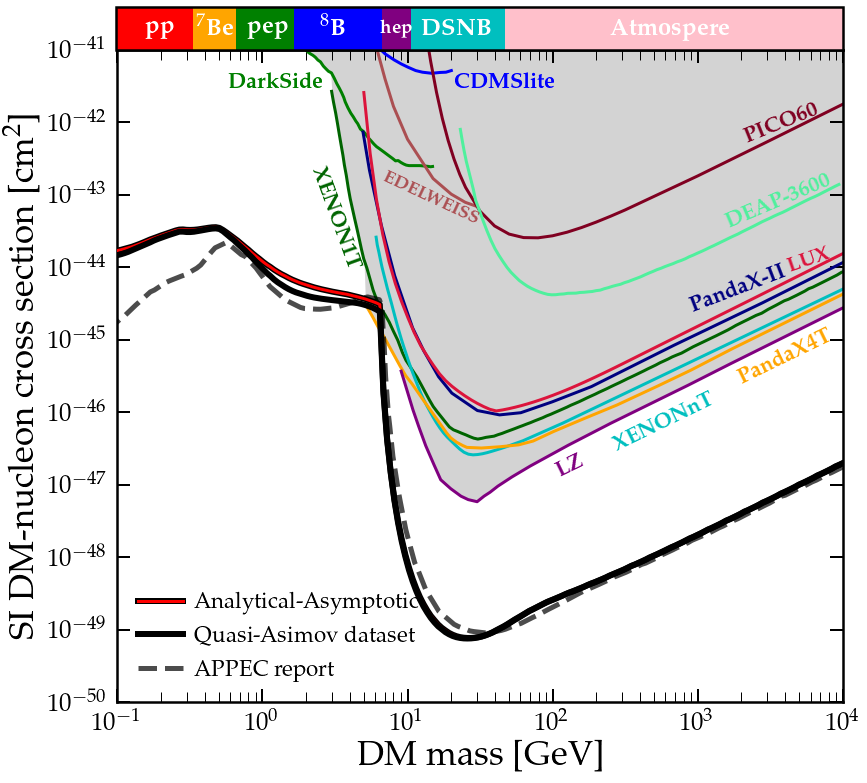

In [12]:
alph = 0.7
nufloor_col = '#e68525'
pek = line_background(6,'k')

#fig,ax = MakeLimitPlot_SI(Annotations=True,Collected=False,ymin=1.0e-50,ymax=1e-37)
fig,ax = MakeLimitPlot_SI2023(Annotations=True,Collected=False,\
                     xmin=1.0e-1,xmax=1.0e4,ymin=1e-50,ymax=1e-41,\
                     facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25,\
                     xlab=r"DM mass [GeV]",ylab=r"SI DM-nucleon cross section [cm$^2$]")

# Our result
plt.plot(NUFLOOR1[0],NUFLOOR1[1],'-',color='r',lw=3,label=r'Analytical-Asymptotic',path_effects=pek,zorder=50)
plt.plot(NUFLOOR2[0],NUFLOOR2[1],'-',color='black',lw=3,label=r'Quasi-Asimov dataset',path_effects=pek,zorder=50)

# APPEC neutrino floor
dat = loadtxt('../data/WIMPLimits/SI/NuFloor_Xe_APPEC.txt')
plt.plot(dat[:,0],dat[:,1],'k--',lw=5,label=r'APPEC report',alpha=0.7)

plt.legend(loc='lower left',frameon=False,handletextpad=0.5, fontsize=22.5)

# label
im = plt.pcolormesh(-np.logspace(-1,2,200),np.logspace(-1,2,1),np.reshape(np.linspace(0.,1.,200),(1,200))\
                    ,cmap=cmap,shading='auto')
#fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.124, 0.88, 0.776, 0.05])
cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
cbar.set_ticks([])
cbar_ax.xaxis.set_ticks_position('top')

textSize = 24
cbar.ax.text(0.04,0.4,r"{\bf pp}",color="white",fontsize=textSize)
cbar.ax.text(0.11,0.35,r"{\bf $^7$Be}",color="white",fontsize=textSize)
cbar.ax.text(0.18,0.4,r"{\bf pep}",color="white",fontsize=textSize)
cbar.ax.text(0.28,0.35,r"{\bf $^8$B}",color="white",fontsize=textSize)
cbar.ax.text(0.363,0.4,r"{\bf hep}",color="white",fontsize=textSize-5)
cbar.ax.text(0.42,0.35,r"{\bf DSNB}",color="white",fontsize=textSize)
cbar.ax.text(0.68,0.35,r"{\bf Atmospere}",color="white",fontsize=textSize)

In [13]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
fig.savefig(os.path.join(myPathFig,'RegeneratingVFloor.pdf'),bbox_inches='tight')
fig.savefig(os.path.join(myPathFig,'png','RegeneratingVFloor.png'),bbox_inches='tight')